In [1]:
# import HandleWeights as hw
import numpy as np
import matplotlib.pyplot as plt
import sys
import mplhep as hep
hep.style.use("ATLAS")
sys.path.append("../DataProcessing")
import ReweightMCDataLoading as rmc
sys.path.append("../Plotting")
import Utils as ut

In [2]:
branches = ["px", "py", "pz", "mass"]  # "charge" only exists for files processed with scan.cc not for pythia8 files
new_mc_name = "HERWIG7"
aleph_mc = rmc.loadDataParticles(
        filePath = rmc.mc_paths["ArchivedPYTHIA6"]["path"],
        treeName = rmc.mc_paths["ArchivedPYTHIA6"]["tree"],
        branches = branches,
        maxNPart = 80,
        padValue = -999
    )
print(aleph_mc.shape)

new_mc = rmc.loadDataParticles(
    filePath = rmc.mc_paths[new_mc_name]["path"], 
    treeName = rmc.mc_paths[new_mc_name]["tree"],
    branches = branches,
    maxNPart = 80,
    padValue = -999
)
print(new_mc.shape)

(973769, 80, 4)
(191125, 80, 4)


In [3]:
reweight = "/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/training-16030e21/Reweight_HERWIG7.reweight.npy"
reweight = np.load(reweight)
print(reweight.shape)
reweight_reshaped = np.tile(reweight[:, np.newaxis, np.newaxis], (1, aleph_mc.shape[1], 1))
print(reweight_reshaped.shape)

(973769,)
(973769, 80, 1)


In [4]:
conf = {
    "px" : {
        "bins" : np.linspace(-50, 50, 51),
        "ax1_ylim" : [10**-5, 10**0]
    },
    "py" : {
        "bins" : np.linspace(-50, 50, 51),
        "ax1_ylim" : [10**-5, 10**0]
    },
    "pz" : {
        "bins" : np.linspace(-50, 50, 51),
        "ax1_ylim" : [10**-5, 10**0]
    },
    "mass" : {
        "bins" : np.linspace(0, 2, 51),
        "ax1_ylim" : [10**-3, 5*10**0]
    },
    "charge" : {
        "bins" : np.linspace(-1, 1, 3),
        "ax1_ylim" : [10**-1, 10**0]
    },
}

In [5]:
plots = {}
for iB, branch in enumerate(branches):
    plots[branch] = {}
    # histogram
    bins = np.linspace(-50, 50, 51)
    # aleph mc
    mask = aleph_mc[:,:,iB].flatten() != -999
    plots[branch][f"h_aleph_mc"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)
    plots[branch][f"hrw_aleph_mc"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True, weights=reweight_reshaped.flatten()[mask])
    # new mc
    mask = new_mc[:,:,iB].flatten() != -999
    plots[branch][f"h_new_mc"] = ut.calc_hist(new_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  ratio = A / B


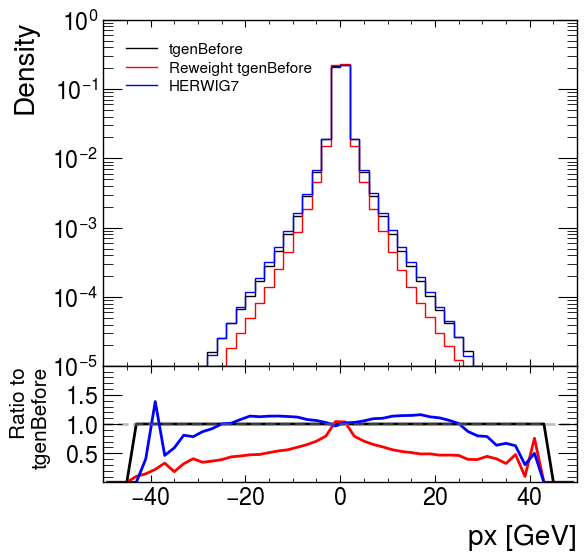

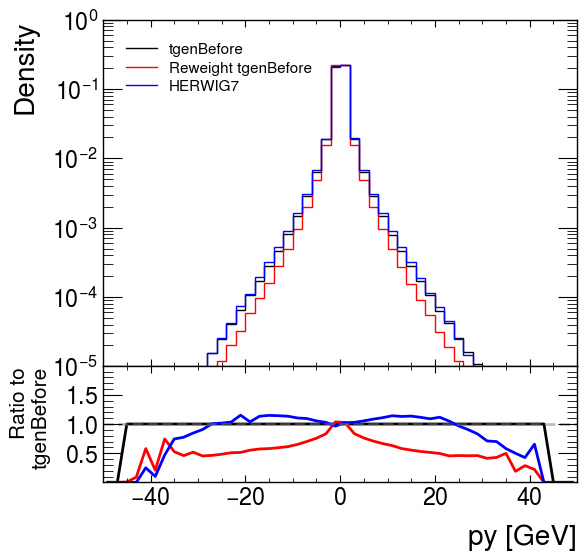

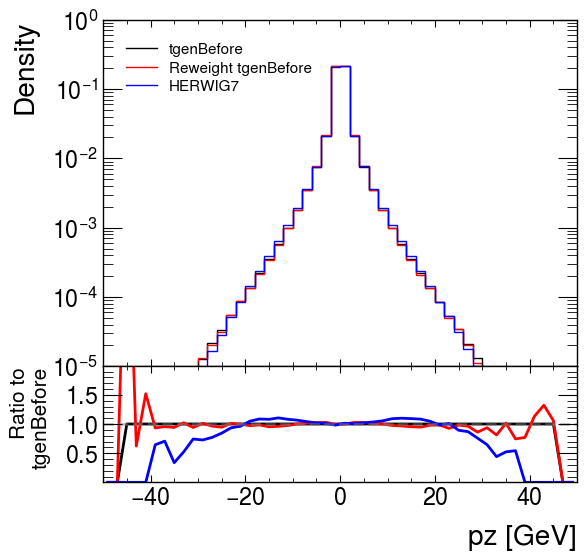

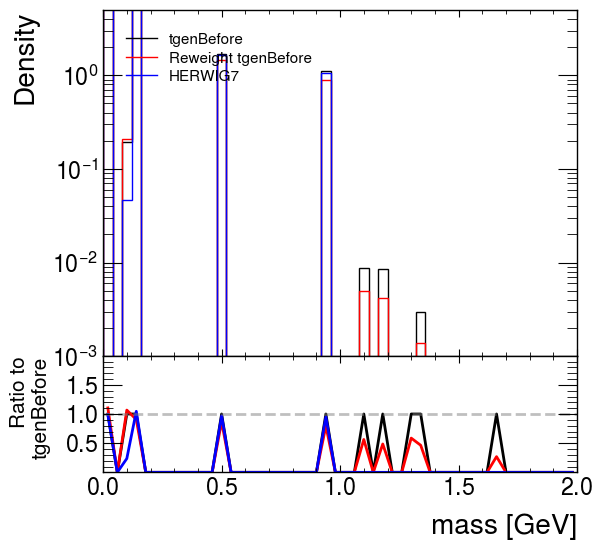

In [6]:
for key, val in plots.items():

    # style
    style = {
        "legend_loc" : "upper left",
        "legend_bbox" : None,
        "legend_ncol" : 1,
        "legend_fontsize" : 11,
        "ax1_ylabel" : "Density",
        "ax1_yscale" : "log",
        "ax2_xlabel" : f"{key}" + ("" if key in ["charge"] else " [GeV]"),
        "ax2_xscale" : "linear",
        "ax2_ylabel" : f'Ratio to\ntgenBefore',
        "ax1_ylim" : conf[key]["ax1_ylim"],
        "bins" : conf[key]["bins"],
        "ax2_ylim" : [0.01, 1.99],
    }

    # plot
    inPlots = {}
    inPlots["tgenBefore"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc"][0], "color": "black", "label": "tgenBefore", "ls":"-"}
    inPlots["rw_tgenBefore"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["hrw_aleph_mc"][0], "color": "red", "label": "Reweight tgenBefore", "ls":"-"}
    inPlots["new_mc"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_new_mc"][0], "color": "blue", "label": new_mc_name, "ls":"-"}

    # ratio denominator using the total error
    ratio_denom = [val["h_aleph_mc"]]

    fig, (ax1, ax2) = ut.plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
    plt.show()
    plt.close()